### Importing Libraries

In [2]:
# Dataframe
import pandas as pd

# Array
import numpy as np

# Decompress the file
import gzip

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline

# Datetime
from datetime import datetime

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Large dataset
#import dask.bag as db

In [3]:
# text preprocessing
import spacy
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.toktok import ToktokTokenizer
import re
#import contractions
import unicodedata
tokenizer = ToktokTokenizer()
#nlp = spacy.load('en', tag=True, entity=True)
from sklearn.feature_extraction.text import CountVectorizer

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import pandas_profiling

In [57]:
import pickle

In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
reviews_df = pd.read_csv("sample30.csv")

In [6]:
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [7]:
reviews_df.shape

(30000, 15)

In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
id                      30000 non-null object
brand                   30000 non-null object
categories              30000 non-null object
manufacturer            29859 non-null object
name                    30000 non-null object
reviews_date            29954 non-null object
reviews_didPurchase     15932 non-null object
reviews_doRecommend     27430 non-null object
reviews_rating          30000 non-null int64
reviews_text            30000 non-null object
reviews_title           29810 non-null object
reviews_userCity        1929 non-null object
reviews_userProvince    170 non-null object
reviews_username        29937 non-null object
user_sentiment          29999 non-null object
dtypes: int64(1), object(14)
memory usage: 3.4+ MB


### Missing Data Report

In [9]:
def get_missing_report(df):
    missing_df = (df.isnull().sum()/len(df)).rename_axis('columns').to_frame('missing_perc').reset_index()
    missing_df['missing_perc'] = missing_df['missing_perc'] * 100
    missing_df['type'] = missing_df['columns'].apply(lambda col: str(df[col].dtypes))
    return missing_df.sort_values(by = 'missing_perc', ascending=False)

In [10]:
get_missing_report(reviews_df)

,columns,missing_perc,type
12,reviews_userProvince,99.433333,object
11,reviews_userCity,93.570000,object
6,reviews_didPurchase,46.893333,object
7,reviews_doRecommend,8.566667,object
10,reviews_title,0.633333,object
3,manufacturer,0.470000,object
13,reviews_username,0.210000,object
5,reviews_date,0.153333,object
14,user_sentiment,0.003333,object
0,id,0.000000,object


Dropping Columns with more than 90% of the data missing and also because 'reviews_userProvince' and 'reviews_userCity' are of no use for sentiment analysis

In [11]:
features_to_remove = ['reviews_userProvince','reviews_userCity','reviews_date']
reviews_df.drop(features_to_remove,axis=1,inplace=True)

In [12]:
reviews_df.shape

(30000, 12)

In [13]:
# Replacing Nan values for remaining columns with appropriate names
reviews_df['reviews_didPurchase'].fillna(False,inplace=True)
reviews_df['reviews_doRecommend'].fillna(False,inplace=True)
reviews_df['reviews_title'].fillna('Unknown Title',inplace=True)
reviews_df['manufacturer'].fillna('Unknown manufacturer',inplace=True)
reviews_df['reviews_username'].fillna('Unknown username',inplace=True)

In [14]:
#Dropping reviews which doesn't have user sentiment
reviews_df = reviews_df[reviews_df['user_sentiment'].notna()]

In [15]:
reviews_df.shape

(29999, 12)

In [16]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 12 columns):
id                     29999 non-null object
brand                  29999 non-null object
categories             29999 non-null object
manufacturer           29999 non-null object
name                   29999 non-null object
reviews_didPurchase    29999 non-null bool
reviews_doRecommend    29999 non-null bool
reviews_rating         29999 non-null int64
reviews_text           29999 non-null object
reviews_title          29999 non-null object
reviews_username       29999 non-null object
user_sentiment         29999 non-null object
dtypes: bool(2), int64(1), object(9)
memory usage: 2.6+ MB


In [17]:
#reviews_df['user_sentiment'] = reviews_df['user_sentiment'].astype('bool')

In [18]:
get_missing_report(reviews_df)

,columns,missing_perc,type
0,id,0.0,object
1,brand,0.0,object
2,categories,0.0,object
3,manufacturer,0.0,object
4,name,0.0,object
5,reviews_didPurchase,0.0,bool
6,reviews_doRecommend,0.0,bool
7,reviews_rating,0.0,int64
8,reviews_text,0.0,object
9,reviews_title,0.0,object


In [19]:
##########################################
## DESCRIPTIVE STATISTICS
##########################################

print ("================================================")

### Total reviews
total = len(reviews_df)
print ("Number of reviews: ",total)
print ()

### How many unique reviewers?
print ("Number of unique reviewers: ",len(reviews_df.id.unique()))
reviewer_prop = float(len(reviews_df.id.unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))
print ()

### How many unique products?
print ("Number of unique products: ", len(reviews_df.name.unique()))
product_prop = float(len(reviews_df.name.unique())/total)
print ("Prop of unique products: ",round(product_prop,3))
print ()

### Average star score
print ("Average rating score: ",round(reviews_df.reviews_rating.mean(),3))


print ("================================================")

Number of reviews:  29999

Number of unique reviewers:  271
Prop of unique reviewers:  0.009

Number of unique products:  271
Prop of unique products:  0.009

Average rating score:  4.483


Text(0, 0.5, 'Number of Reviews')

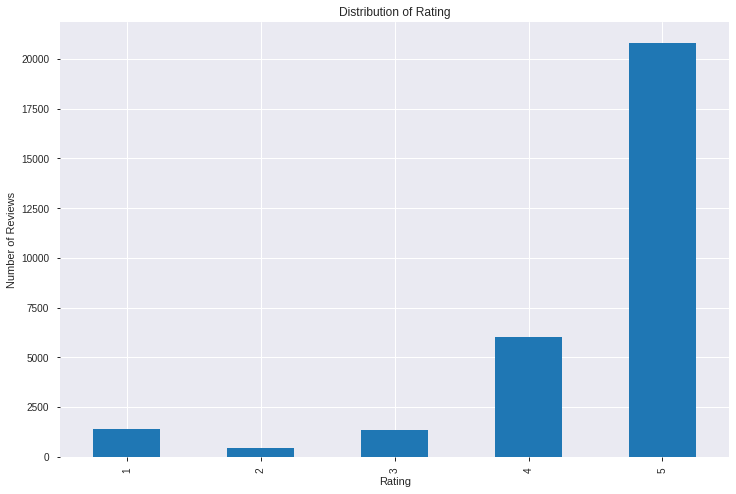

In [20]:
##########################################
## PLOT DISTRIBUTION OF RATING 
##########################################

plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
reviews_df['reviews_rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

In [21]:
reviews_df['user_sentiment'].value_counts(normalize=True)

Positive    0.887763
Negative    0.112237
Name: user_sentiment, dtype: float64

In [ ]:
pandas_profiling.ProfileReport(reviews_df)

In [22]:
##########################################
## CONCATENATE REVIEWTEXT AND SUMMARY 
##########################################

reviews_df['review'] = reviews_df[['reviews_title', 'reviews_text']].apply(lambda x: " ".join(str(y) for y in x if str(y) != 'nan'), axis = 1)
reviews_df = reviews_df.drop(['reviews_title', 'reviews_text'], axis = 1)
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,review
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),False,False,5,joshua,Positive,Just Awesome i love this album. it's very good...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor. This review was collected as...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,rebecca,Negative,Disappointed I read through the reviews on her...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,walker557,Negative,Irritation My husband bought this gel for us. ...


In [23]:
# Statistics of non-numeric variables

# Number of unique customers
print('\nNumber of unique customers : {}'.format(len(reviews_df['reviews_username'].unique())))
      
# Number of unique products
print('\nNumber of unique products : {}'.format(len(reviews_df['name'].unique())))
      
# Review number per unique customer
print('\nReview per customer: {}'.format((len(reviews_df)/len(reviews_df['reviews_username'].unique()))))      

# Review number per unique product 
print('\nReview per product: {}'.format((len(reviews_df)/len(reviews_df['name'].unique()))))


Number of unique customers : 24915

Number of unique products : 271

Review per customer: 1.20405378286173

Review per product: 110.69741697416974


### Text Preprocessing
The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.

In [24]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import unicodedata
import contractions
#from contractions import CONTRACTION_MAP
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
# calculate raw tokens in order to measure of cleaned tokens

from nltk.tokenize import word_tokenize
raw_tokens=len([w for t in (reviews_df["review"].apply(word_tokenize)) for w in t])
print('Number of raw tokens: {}'.format(raw_tokens))

Number of raw tokens: 1274211


### Lemmatization
The process of lemmatization is to remove word affixes to get to a base form of the word. The base form is also known as the root word, or the lemma, will always be present in the dictionary.

In [26]:
import re, string, unicodedata
#import contractions
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

In [27]:
from contractions import contractions_dict

In [28]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text



# Define function to expand contractions
def expand_contractions(text):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match)\
                        if contractions_dict.get(match)\
                        else contractions_dict.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# special_characters removal
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words


def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words


def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

stopword_list= stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
#stopword_list.remove('headphone')
#stopword_list.remove('headphones')
#stopword_list.remove('earbuds')
#stopword_list.remove('bud')
#stopword_list.remove('ear')
#stopword_list.remove('sony')
#stopword_list.remove('product')


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems


def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

In [29]:
def normalize_and_lemmaize(input):
    sample = denoise_text(input)
    #sample = expand_contractions(sample)
    sample = remove_special_characters(sample)
    words = nltk.word_tokenize(sample)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [30]:
reviews_df['review_cleaned'] = reviews_df['review'].map(lambda text: normalize_and_lemmaize(text))

In [31]:
reviews_df.head()

,id,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,review,review_cleaned
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),False,False,5,joshua,Positive,Just Awesome i love this album. it's very good...,awesome love album good hip hop side current p...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor. This review was collected as...,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor.,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,rebecca,Negative,Disappointed I read through the reviews on her...,disappoint read review look buy one couple lub...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,False,False,1,walker557,Negative,Irritation My husband bought this gel for us. ...,irritation husband buy gel us gel cause irrita...


### Cleaning the Text

In [32]:
# Let's put aside number of raw tokens in order to measure of cleaned tokens
from nltk.tokenize import word_tokenize
clean_tokens=len([w for t in (reviews_df["review_cleaned"].apply(word_tokenize)) for w in t])
#clean_tokens=len((product_reviews_hp4["clean_text"]))
print('Number of clean tokens: {}\n'.format(clean_tokens))
print('Percentage of removed tokens: {0:.2f}'.format(1-(clean_tokens/raw_tokens)))

Number of clean tokens: 599695

Percentage of removed tokens: 0.53


In [33]:
from nltk.tokenize import RegexpTokenizer
def RegExpTokenizer(Sent):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(Sent)

ListWords = []
for m in reviews_df['review_cleaned']:
    n = RegExpTokenizer(str(m))
    ListWords.append(n)
print(ListWords[10])

['pretty', 'dissapoitned', 'try', 'husband', 'felt', 'no', 'different', 'no', 'effect', 'no', 'change', 'first', 'te', 'use', 'ky', 'gel', 'not', 'sure', 'want', 'try', 'others']


In [34]:
#All Words
from nltk import FreqDist
def Bag_Of_Words(ListWords):
    all_words = []
    for m in ListWords:
        for w in m:
            all_words.append(w.lower())
    all_words1 = FreqDist(all_words)
    return all_words1

In [33]:
import matplotlib as mpl
from wordcloud import WordCloud
all_words = Bag_Of_Words(ListWords)
ax = plt.figure(figsize=(15,10))
# Generate a word cloud image
wordcloud = WordCloud(background_color='white',max_font_size=40).generate(' '.join(all_words.keys()))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
print("Combien de Mots !!!",len(all_words))

ModuleNotFoundError: No module named 'wordcloud'

<AxesSubplot:>

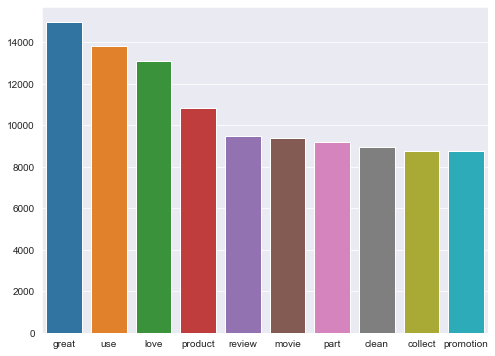

In [52]:
plt.figure(figsize = (8,6))
import seaborn as sns
from sklearn.manifold import TSNE
all_words = Bag_Of_Words(ListWords)
count = []
Words  = []
for w in all_words4.most_common(10):
    count.append(w[1])
    Words.append(w[0])
sns.set_style("darkgrid")
sns.barplot(Words,count)

Text(0, 0.5, 'Number of Reviews')

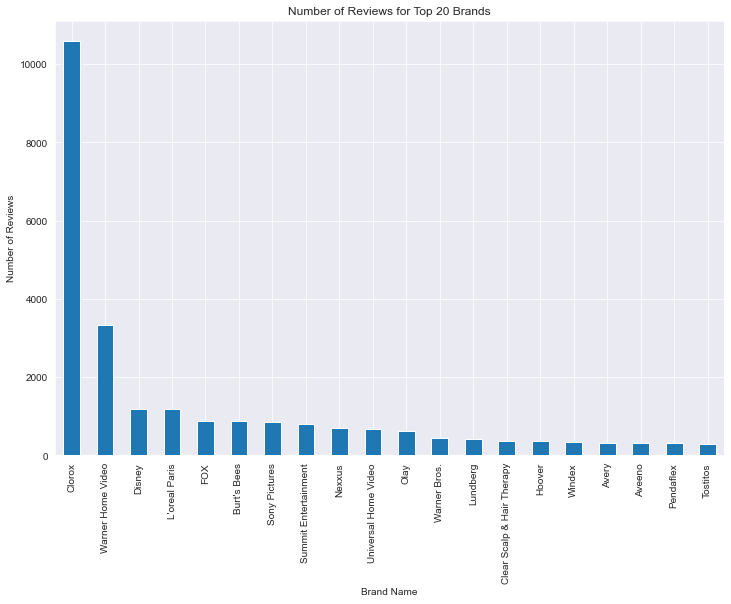

In [55]:
##########################################
## PLOT NUMBER OF REVIEWS FOR TOP 20 BRANDS  
##########################################

brands = reviews_df["brand"].value_counts()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Reviews')

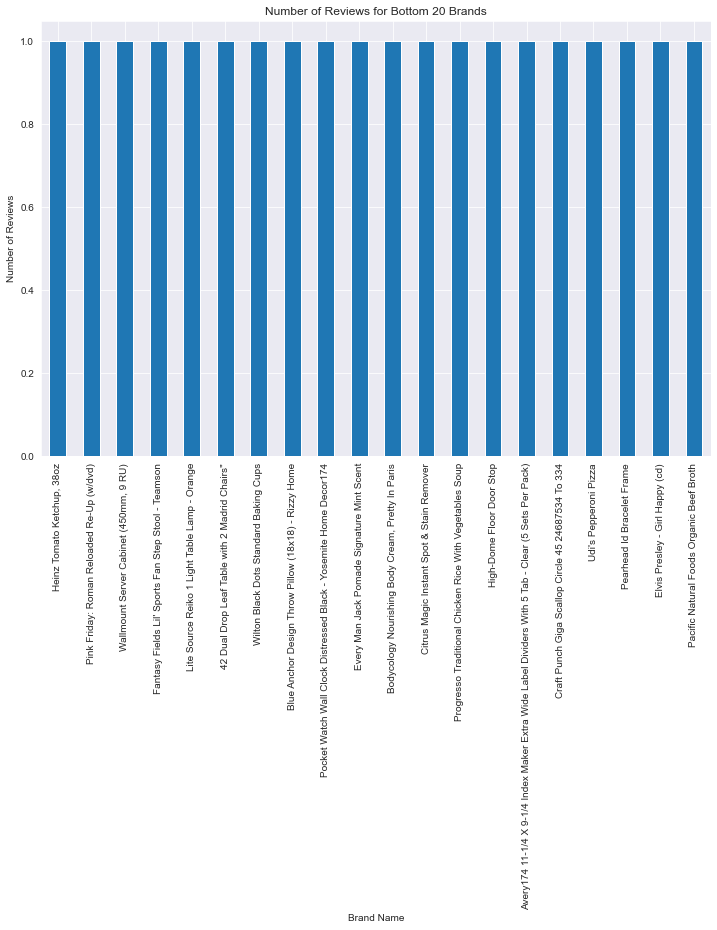

In [54]:
##########################################
## PLOT NUMBER OF REVIEWS FOR BOTTOM 20 BRANDS  
##########################################

brands = reviews_df["name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[-20:].plot(kind='bar')
plt.title("Number of Reviews for Bottom 20 Brands")
plt.xlabel('Brand Name')
plt.ylabel('Number of Reviews')

Text(0, 0.5, 'Number of Reviews')

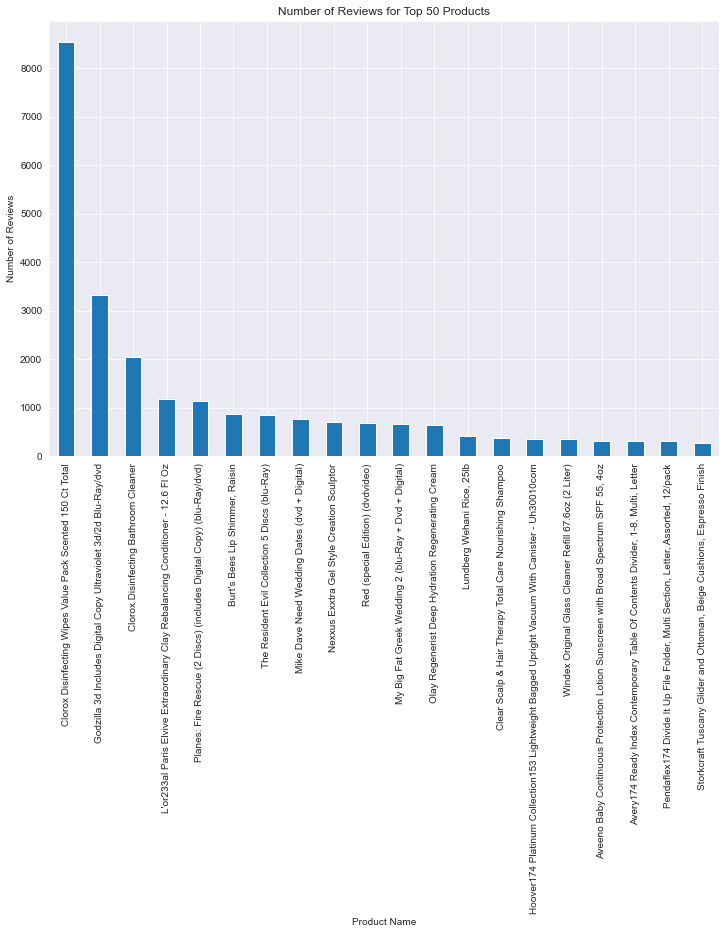

In [56]:
##########################################
## PLOT NUMBER OF REVIEWS FOR TOP 20 PRODUCTS  
##########################################

products = reviews_df["name"].value_counts()
plt.figure(figsize=(12,8))
products[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")
plt.xlabel('Product Name')
plt.ylabel('Number of Reviews')

In [57]:
low_rating_reviews_df = reviews_df[reviews_df['reviews_rating'] < 3]

Text(0, 0.5, 'Number of Reviews')

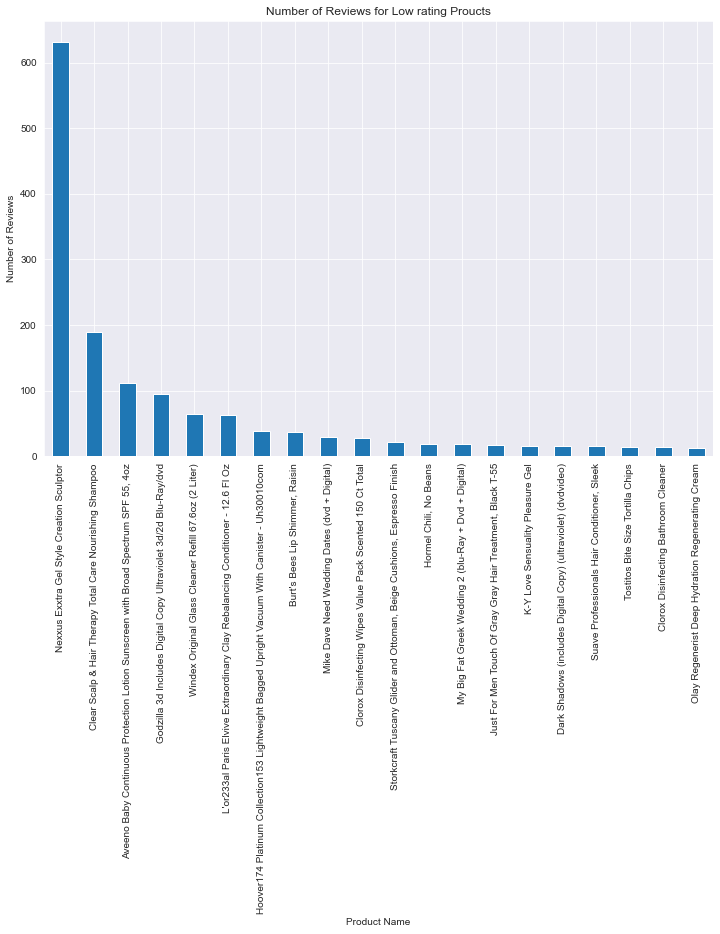

In [59]:
##########################################
## PLOT NUMBER OF REVIEWS FOR LOW RATING PRODUCTS  
##########################################

products = low_rating_reviews_df["name"].value_counts()
plt.figure(figsize=(12,8))
products[:20].plot(kind='bar')
plt.title("Number of Reviews for Low rating Proucts")
plt.xlabel('Product Name')
plt.ylabel('Number of Reviews')

In [35]:
# Function for creating a column token
def token (text):
    token = [w for w in nltk.word_tokenize(text)]
    return token

# To create token feature
reviews_df['token'] = reviews_df['review_cleaned'].apply(token)

In [36]:
# Function for creating a column to see the length of the review text
def length(text):
    length = len([w for w in nltk.word_tokenize(text)])
    return length

# Apply length function to create review length feature
reviews_df['review_length'] = reviews_df['review'].apply(length)
reviews_df.head(3)

,id,brand,categories,manufacturer,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_username,user_sentiment,review,review_cleaned,token,review_length
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),False,False,5,joshua,Positive,Just Awesome i love this album. it's very good...,awesome love album good hip hop side current p...,"[awesome, love, album, good, hip, hop, side, c...",51
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor. This review was collected as...,good good flavor review collect part promotion,"[good, good, flavor, review, collect, part, pr...",14
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,True,False,5,dorothy w,Positive,Good Good flavor.,good good flavor,"[good, good, flavor]",4


### Sentiment Analysis (CV-TF_IDF-HASH)

In [37]:
import unicodedata
from nltk.tokenize import ToktokTokenizer
# import spacy
tokenizer = ToktokTokenizer()
# nlp = spacy.load('en', parse=True, tag=True, entity=True)

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
#from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [38]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [39]:
from collections import Counter

In [40]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve

In [41]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [42]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 14 columns):
id                     29999 non-null object
brand                  29999 non-null object
categories             29999 non-null object
manufacturer           29999 non-null object
name                   29999 non-null object
reviews_didPurchase    29999 non-null bool
reviews_doRecommend    29999 non-null bool
reviews_rating         29999 non-null int64
reviews_username       29999 non-null object
user_sentiment         29999 non-null object
review                 29999 non-null object
review_cleaned         29999 non-null object
token                  29999 non-null object
review_length          29999 non-null int64
dtypes: bool(2), int64(2), object(10)
memory usage: 3.0+ MB


In [43]:
reviews_df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_username', 'user_sentiment', 'review', 'review_cleaned',
       'token', 'review_length'],
      dtype='object')

In [44]:
#Dropping unncessary columns
reviews_df_final = reviews_df[['name','reviews_rating',
       'reviews_username', 'user_sentiment', 'review', 'review_cleaned',
       'token']]

In [45]:
reviews_df_final.head()

,name,reviews_rating,reviews_username,user_sentiment,review,review_cleaned,token
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,Just Awesome i love this album. it's very good...,awesome love album good hip hop side current p...,"[awesome, love, album, good, hip, hop, side, c..."
1,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good Good flavor. This review was collected as...,good good flavor review collect part promotion,"[good, good, flavor, review, collect, part, pr..."
2,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good Good flavor.,good good flavor,"[good, good, flavor]"
3,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,Disappointed I read through the reviews on her...,disappoint read review look buy one couple lub...,"[disappoint, read, review, look, buy, one, cou..."
4,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,Irritation My husband bought this gel for us. ...,irritation husband buy gel us gel cause irrita...,"[irritation, husband, buy, gel, us, gel, cause..."


### Natural Language Processing

### Data Preprocessing

In [46]:
reviews_df_final['user_sentiment'] = reviews_df_final['user_sentiment'].apply(lambda x: 0 if x == 'Negative' else 1)

In [47]:
# Splitting the Data Set into Train and Test Sets
X = reviews_df_final['review_cleaned']
y = reviews_df_final['user_sentiment']

### Splitting Dataset into Train and Test Set
We split our data in to a training set used to fit our model and a test set to see how well it generalizes to unseen data.

In [48]:
# Splitting Dataset into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [49]:
# Print train and test set shape
print ('Train Set Shape\t\t:{}\nTest Set Shape\t\t:{}'.format(X_train.shape, X_test.shape))

Train Set Shape		:(22499,)
Test Set Shape		:(7500,)


In [50]:
y_train.value_counts()/len(y_train)

1    0.886751
0    0.113249
Name: user_sentiment, dtype: float64

In [51]:
y_test.value_counts()/len(y_test)

1    0.8908
0    0.1092
Name: user_sentiment, dtype: float64

### Selecting the Right Evaluation Metric
Since the data is imbalanced, the evaluation of the classifier performance must be carried out using adequate metrics in order to take into account the class distribution and to pay more attention to the minority class. When the positive class is smaller and the ability to detect correctly positive samples is our main focus (correct detection of negatives examples is less important to the problem) we should use precision and recall. For our particular case, based on this thought I will use f1 score which is harmonic average of precision and recall as my evaluation metric.

### Confusion Matrix Plot Function
Understanding the types of errors our model makes, and least desirable are important . A good way to visualize that information is using a Confusion Matrix, which compares the predictions our model makes with the true label. With that in mind, we used confusion matrix besides our evaluation metric (f1 score).

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

In [53]:
def disp_confusion_matrix(y_pred, model_name, vector = 'CounterVectorizing'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Bad','Good'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

### Modelling
This is a supervised binary classification problem. We are trying to predict the sentiment based on the reviews left by customers who bought headphones products in Amazon e-commerce online platform. We used Python’s Scikit Learn libraries to solve the problem. In this context, we implemented Logistic Regression, Random Forest, Naive Bayes, XGBOOST, and Catboost algorithms. Besides that, I implemented deep learning technique with Keras.

For feature selection, I applied threshold for word occurence with using min_df/max_df, PCA and Singular Value Decomposition.

For feature engineering, I applied CountVectorizer, TF-IDF, Hashing Vectorizer and Word2Vec to the text data in order to turn a collection of text documents into numerical feature vectors.

### CountVectorizer Bag of Words
We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

"CountVectorizer" implements both tokenization and occurrence counting in a single class.

In [54]:
# Create the word vector with CountVectorizer
count_vect = CountVectorizer(stop_words='english',max_features=5000)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [55]:
# Print vocabulary length
print('Vocabulary length :', len(count_vect.get_feature_names()))

Vocabulary length : 5000


In [56]:
# Assign feature names of vector into a variable
vocab = count_vect.get_feature_names()

In [57]:
# Dataframe for train countvectorizer dataset
pd.DataFrame(count_vect_train, columns = vocab).head()

,aaron,abilities,ability,able,abrasive,absolute,absolutely,absolutly,absorb,academy,...,zac,zach,zero,zilla,zinc,zip,ziploc,zombie,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Handling class imbalance using SMOTE based techniques

### A) SMOTE Technique

In [58]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(count_vect_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({1: 19951, 0: 2548})
After Counter({1: 19951, 0: 19951})


### B) ADASYN Technique

In [ ]:
# from imblearn.over_sampling import ADASYN

# counter = Counter(y_train)
# print('Before',counter)
# # oversampling the train dataset using ADASYN
# ada = ADASYN(random_state=130)
# X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

# counter = Counter(y_train_ada)
# print('After',counter)

### C) SMOTE + Tomek Links

In [ ]:
from imblearn.combine import SMOTETomek

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

In [82]:
model_cv = list()
resample_cv = list()
precision_cv = list()
precision_neg_cv = list()
recall_neg_cv = list()
recall_cv = list()
F1score_cv = list()
AUCROC_cv = list()

In [63]:
def get_recall_negative_class(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = matrix
    recall_neg = tn / (tn + fp)
    return recall_neg

def get_precision_negative_class(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred).ravel()
    tn, fp, fn, tp = matrix
    precision_neg = tn / (tn + fn)
    return precision_neg

In [61]:
def test_eval(clf_model,y_pred,y_prob ,y_test, algo=None, sampling=None):
    # Test set prediction
#     y_prob=clf_model.predict_proba(X_test)
#     y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
    score = f1_score(y_test, y_pred, average = 'weighted')
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))
          
    model_cv.append(algo)
    precision_cv.append(precision_score(y_test,y_pred))
    recall_cv.append(recall_score(y_test,y_pred))
    F1score_cv.append(score)
    AUCROC_cv.append(roc_auc_score(y_test, y_prob[:,1]))
    resample_cv.append(sampling)
    precision_neg_cv.append(get_precision_negative_class(y_test,y_pred))
    recall_neg_cv.append(get_recall_negative_class(y_test,y_pred))

### Using Original unsampled Data

In [62]:
clf_LR_countvec = LogisticRegression(random_state = 123)
clf_RF_countvec = RandomForestClassifier(random_state = 123)
clf_XGB_countvec = XGBClassifier(random_state = 123)

In [63]:
# #hyperparameter
lr_params = {'penalty': ['l1', 'l2'], 
             'solver': ['lbfgs', 'liblinear'], 
             'C': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]}
rf_params = {'n_estimators':[200,300,500], 'max_depth':[4,6]
              , 'min_samples_split':[100,300], 'min_samples_leaf':[50,100]}
xgb_params = {'n_estimators':[200],
    "learning_rate"    : [0.1, 0.30],
 "max_depth"        : [6,10],
# "min_child_weight" : [ 5, 7 ],
 "gamma"            : [0,10,30]}
# 'reg_alpha': [1e-2,1,3], 
# 'reg_lambda': [3,5],
# "colsample_bytree" : [ 0.1,0.3]}

In [64]:
# storing model object and hyperparameters in a dictionary
model_dict = {
             'logistic_reg': [clf_LR_countvec, lr_params], 
             'random_forest': [clf_RF_countvec, rf_params],
              'xgboost': [clf_XGB_countvec, xgb_params]}

In [65]:
# list to store best model and results
trained_models = []
# train each ensemble model one by one
# tqdm to show progress
for model_name in tqdm(model_dict):
    print('Training %s model ' %model_name)
    model_entity = model_dict[model_name]
    estimator = model_entity[0]
    estimator_params = model_entity[1]
    # Grid search for hyperparameter tuning
    # Randomized search for faster hyperparameter tuning (Use n_iter=10 or any number to limit in case of randomized search, use n_jobs=-1 to use all cores, use k in KFold() if needed)
    # StratiedfiedKFold for model cross-validation
    estimator_grid_model = GridSearchCV(estimator=estimator, param_grid=estimator_params, cv=StratifiedKFold(), n_jobs=-1, verbose=4)
    #estimator_grid_model = RandomizedSearchCV(estimator=estimator, param_distributions=estimator_params, cv=StratifiedKFold(), n_jobs=1, n_iter=10)
    estimator_grid_model.fit(count_vect_train, y_train)
    print('\n %s Model training complete.' %model_name)
    # get test results
    y_pred_grid_model = estimator_grid_model.predict(count_vect_test)
    # get test probabilities
    y_pred_prob_grid_model = estimator_grid_model.predict_proba(count_vect_test)
    # store model name with best estimator and results in a dict object
    trained_model_dict = {}
    trained_model_dict['model_name'] = model_name
    trained_model_dict['best_estimator'] = estimator_grid_model.best_estimator_
    trained_model_dict['y_pred'] = y_pred_grid_model
    trained_model_dict['y_pred_prob'] = y_pred_prob_grid_model
    # append to results to list
    trained_models.append(trained_model_dict)
# trained_models

  0%|          | 0/3 [00:00<?, ?it/s]

Training logistic_reg model 
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 logistic_reg Model training complete.


 33%|███▎      | 1/3 [00:43<01:27, 44.00s/it]

Training random_forest model 
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 random_forest Model training complete.


 67%|██████▋   | 2/3 [02:47<01:07, 67.96s/it]

Training xgboost model 
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 xgboost Model training complete.


100%|██████████| 3/3 [29:23<00:00, 587.75s/it]


### Logistic Regression with Count Vectorizer

In [66]:
clf_LR_countvec = trained_models[0]['best_estimator']
y_pred_cv_LR = trained_models[0]['y_pred']
y_prob_cv_LR = trained_models[0]['y_pred_prob']

In [83]:
test_eval(clf_LR_countvec,y_pred_cv_LR,y_prob_cv_LR,y_test,'Logistic Regression CountVec','actual')

Confusion Matrix
[[ 407  412]
 [ 212 6469]] 

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.50      0.57       819
           1       0.94      0.97      0.95      6681

    accuracy                           0.92      7500
   macro avg       0.80      0.73      0.76      7500
weighted avg       0.91      0.92      0.91      7500
 

AUC-ROC
0.9301207532011304
f1 score: 0.9116276652078876


In [72]:
# save the model to disk
filename = 'LR_countvec_actual.sav'
pickle.dump(clf_LR_countvec, open(filename, 'wb'))

### Random Forest with Countvectorizer

In [73]:
clf_RF_countvec = trained_models[1]['best_estimator']
y_pred_cv_RF = trained_models[1]['y_pred']
y_prob_cv_RF = trained_models[1]['y_pred_prob']

In [84]:
test_eval(clf_RF_countvec,y_pred_cv_RF,y_prob_cv_RF,y_test,'Random Forest CountVec','actual')

Confusion Matrix
[[   0  819]
 [   0 6681]] 

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       819
           1       0.89      1.00      0.94      6681

    accuracy                           0.89      7500
   macro avg       0.45      0.50      0.47      7500
weighted avg       0.79      0.89      0.84      7500
 

AUC-ROC
0.8207619186514561
f1 score: 0.8393533319229955


In [75]:
# save the model to disk
filename = 'RF_countvec_actual.sav'
pickle.dump(clf_RF_countvec, open(filename, 'wb'))

### XGBoost with Countvectorizer

In [76]:
clf_XGB_countvec = trained_models[2]['best_estimator']
y_pred_cv_XGB = trained_models[2]['y_pred']
y_prob_cv_XGB = trained_models[2]['y_pred_prob']

In [85]:
test_eval(clf_XGB_countvec,y_pred_cv_XGB,y_prob_cv_XGB,y_test,'XGboost CountVec','actual')

Confusion Matrix
[[ 382  437]
 [ 158 6523]] 

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.47      0.56       819
           1       0.94      0.98      0.96      6681

    accuracy                           0.92      7500
   macro avg       0.82      0.72      0.76      7500
weighted avg       0.91      0.92      0.91      7500
 

AUC-ROC
0.9261670741239668
f1 score: 0.9133344829645339


In [78]:
# save the model to disk
filename = 'XGB_countvec_actual.sav'
pickle.dump(clf_XGB_countvec, open(filename, 'wb'))

### Naive Bayes with Countvectorizer

In [88]:
clf_NB_countvec = MultinomialNB()

In [89]:
clf_NB_countvec.fit(count_vect_train, y_train)

MultinomialNB()

In [93]:
y_prob_cv_NB=clf_NB_countvec.predict_proba(count_vect_test)
y_pred_cv_NB=clf_NB_countvec.predict(count_vect_test)

In [94]:
test_eval(clf_NB_countvec,y_pred_cv_NB,y_prob_cv_NB,y_test,'Naive Bayes CountVec','actual')

Confusion Matrix
[[ 274  545]
 [ 427 6254]] 

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.33      0.36       819
           1       0.92      0.94      0.93      6681

    accuracy                           0.87      7500
   macro avg       0.66      0.64      0.64      7500
weighted avg       0.86      0.87      0.87      7500
 

AUC-ROC
0.8468053757681059
f1 score: 0.8659367140402936


In [95]:
# save the model to disk
filename = 'NB_countvec_actual.sav'
pickle.dump(clf_NB_countvec, open(filename, 'wb'))

### Using SMOTE Technique

In [96]:
clf_LR_countvec_smote = LogisticRegression(random_state = 123)
clf_RF_countvec_smote = RandomForestClassifier(random_state = 123)
clf_XGB_countvec_smote = XGBClassifier(random_state = 123)

In [97]:
# storing model object and hyperparameters in a dictionary
model_dict_smote = {
             'logistic_reg': [clf_LR_countvec_smote, lr_params], 
             'random_forest': [clf_RF_countvec_smote, rf_params],
              'xgboost': [clf_XGB_countvec_smote, xgb_params]}

In [98]:
# list to store best model and results
trained_models_smote = []
# train each ensemble model one by one
# tqdm to show progress
for model_name in tqdm(model_dict_smote):
    print('Training %s model ' %model_name)
    model_entity = model_dict_smote[model_name]
    estimator = model_entity[0]
    estimator_params = model_entity[1]
    # Grid search for hyperparameter tuning
    # Randomized search for faster hyperparameter tuning (Use n_iter=10 or any number to limit in case of randomized search, use n_jobs=-1 to use all cores, use k in KFold() if needed)
    # StratiedfiedKFold for model cross-validation
    estimator_grid_model = GridSearchCV(estimator=estimator, param_grid=estimator_params, cv=StratifiedKFold(), n_jobs=-1, verbose=4)
    #estimator_grid_model = RandomizedSearchCV(estimator=estimator, param_distributions=estimator_params, cv=StratifiedKFold(), n_jobs=1, n_iter=10)
    estimator_grid_model.fit(X_train_sm, y_train_sm)
    print('\n %s Model training complete.' %model_name)
    # get test results
    y_pred_grid_model = estimator_grid_model.predict(count_vect_test)
    # get test probabilities
    y_pred_prob_grid_model = estimator_grid_model.predict_proba(count_vect_test)
    # store model name with best estimator and results in a dict object
    trained_model_dict = {}
    trained_model_dict['model_name'] = model_name
    trained_model_dict['best_estimator'] = estimator_grid_model.best_estimator_
    trained_model_dict['y_pred'] = y_pred_grid_model
    trained_model_dict['y_pred_prob'] = y_pred_prob_grid_model
    # append to results to list
    trained_models_smote.append(trained_model_dict)
# trained_models

  0%|          | 0/3 [00:00<?, ?it/s]

Training logistic_reg model 
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 logistic_reg Model training complete.


 33%|███▎      | 1/3 [01:15<02:30, 75.25s/it]

Training random_forest model 
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 random_forest Model training complete.


 67%|██████▋   | 2/3 [05:53<02:16, 136.18s/it]

Training xgboost model 
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 xgboost Model training complete.


100%|██████████| 3/3 [53:33<00:00, 1071.22s/it]


### Logistic Regression with Count Vectorizer

In [99]:
clf_LR_countvec_smote = trained_models_smote[0]['best_estimator']
y_pred_cv_LR_smote = trained_models_smote[0]['y_pred']
y_prob_cv_LR_smote = trained_models_smote[0]['y_pred_prob']

In [100]:
test_eval(clf_LR_countvec_smote,y_pred_cv_LR_smote,y_prob_cv_LR_smote,y_test,'Logistic Regression CountVec','SMOTE')

Confusion Matrix
[[ 531  288]
 [ 482 6199]] 

Classification Report
              precision    recall  f1-score   support

           0       0.52      0.65      0.58       819
           1       0.96      0.93      0.94      6681

    accuracy                           0.90      7500
   macro avg       0.74      0.79      0.76      7500
weighted avg       0.91      0.90      0.90      7500
 

AUC-ROC
0.9013931402795345
f1 score: 0.9020130089087213


In [101]:
# save the model to disk
filename = 'LR_countvec_smote.sav'
pickle.dump(clf_LR_countvec_smote, open(filename, 'wb'))

### Random Forest with Countvectorizer

In [104]:
clf_RF_countvec_smote = trained_models_smote[1]['best_estimator']
y_pred_cv_RF_smote = trained_models_smote[1]['y_pred']
y_prob_cv_RF_smote = trained_models_smote[1]['y_pred_prob']

In [105]:
test_eval(clf_RF_countvec_smote,y_pred_cv_RF_smote,y_prob_cv_RF_smote,y_test,'Random Forest CountVec','SMOTE')

Confusion Matrix
[[ 516  303]
 [1302 5379]] 

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.63      0.39       819
           1       0.95      0.81      0.87      6681

    accuracy                           0.79      7500
   macro avg       0.62      0.72      0.63      7500
weighted avg       0.87      0.79      0.82      7500
 

AUC-ROC
0.7917041547486092
f1 score: 0.8178896337994107


In [106]:
# save the model to disk
filename = 'RF_countvec_smote.sav'
pickle.dump(clf_RF_countvec_smote, open(filename, 'wb'))

### XGBoost with Countvectorizer

In [108]:
clf_XGB_countvec_smote = trained_models_smote[2]['best_estimator']
y_pred_cv_XGB_smote = trained_models_smote[2]['y_pred']
y_prob_cv_XGB_smote = trained_models_smote[2]['y_pred_prob']

In [109]:
test_eval(clf_XGB_countvec_smote,y_pred_cv_XGB_smote,y_prob_cv_XGB_smote,y_test,'XGboost CountVec','SMOTE')

Confusion Matrix
[[ 504  315]
 [ 407 6274]] 

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       819
           1       0.95      0.94      0.95      6681

    accuracy                           0.90      7500
   macro avg       0.75      0.78      0.76      7500
weighted avg       0.91      0.90      0.91      7500
 

AUC-ROC
0.9028621430956411
f1 score: 0.9059593199489483


In [110]:
# save the model to disk
filename = 'XGB_countvec_smote.sav'
pickle.dump(clf_XGB_countvec_smote, open(filename, 'wb'))

### Naive Bayes with Countvectorizer

In [111]:
clf_NB_countvec_smote = MultinomialNB()
clf_NB_countvec_smote.fit(X_train_sm, y_train_sm)

MultinomialNB()

In [112]:
y_prob_cv_NB_smote=clf_NB_countvec_smote.predict_proba(count_vect_test)
y_pred_cv_NB_smote=clf_NB_countvec_smote.predict(count_vect_test)

In [113]:
test_eval(clf_NB_countvec_smote,y_pred_cv_NB_smote,y_prob_cv_NB_smote,y_test,'Naive Bayes CountVec','SMOTE')

Confusion Matrix
[[ 406  413]
 [ 974 5707]] 

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.50      0.37       819
           1       0.93      0.85      0.89      6681

    accuracy                           0.82      7500
   macro avg       0.61      0.67      0.63      7500
weighted avg       0.86      0.82      0.83      7500
 

AUC-ROC
0.7653177536428546
f1 score: 0.8346040652306643


In [114]:
# save the model to disk
filename = 'NB_countvec_smote.sav'
pickle.dump(clf_NB_countvec_smote, open(filename, 'wb'))

In [115]:
clf_eval_df = pd.DataFrame({'model':model_cv,
                            'resample':resample_cv,
                            'precision':precision_cv,
                            'recall':recall_cv,
                            'f1-score':F1score_cv,
                            'AUC-ROC':AUCROC_cv,
                           'recall_neg':recall_neg_cv,
                           'precision_neg':precision_neg_cv})

In [116]:
clf_eval_df

,model,resample,precision,recall,f1-score,AUC-ROC,recall_neg,precision_neg
0,Logistic Regression CountVec,actual,0.940125,0.968268,0.911628,0.930121,0.496947,0.657512
1,Random Forest CountVec,actual,0.890800,1.000000,0.839353,0.820762,0.000000,NaN
2,XGboost CountVec,actual,0.937213,0.976351,0.913334,0.926167,0.466422,0.707407
3,Naive Bayes CountVec,actual,0.919841,0.936087,0.865937,0.846805,0.334554,0.390870
4,Logistic Regression CountVec,SMOTE,0.955604,0.927855,0.902013,0.901393,0.648352,0.524186
5,Random Forest CountVec,SMOTE,0.890800,1.000000,0.839353,0.820762,0.000000,NaN
6,Random Forest CountVec,SMOTE,0.946674,0.805119,0.817890,0.791704,0.630037,0.283828
7,XGboost CountVec,SMOTE,0.952193,0.939081,0.905959,0.902862,0.615385,0.553238
8,Naive Bayes CountVec,SMOTE,0.932516,0.854213,0.834604,0.765318,0.495726,0.294203


### TF-IDF

In [54]:
# Create the word vector with TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1),max_features=5000)
tfidf_vect_train = tfidf_vect.fit_transform(X_train)
tfidf_vect_train = tfidf_vect_train.toarray()
tfidf_vect_test = tfidf_vect.transform(X_test)
tfidf_vect_test = tfidf_vect_test.toarray()

In [64]:
model_tf_idf = list()
resample_tf_idf = list()
precision_tf_idf = list()
precision_neg_tf_idf = list()
recall_neg_tf_idf = list()
recall_tf_idf = list()
F1score_tf_idf = list()
AUCROC_tf_idf = list()

In [59]:
def test_eval_tf_idf(clf_model,y_pred,y_prob, y_test, algo=None, sampling=None):
    # Test set prediction
    #y_prob=clf_model.predict_proba(X_test)
    #y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
    score = f1_score(y_test, y_pred, average = 'weighted')
    # Printing evaluation metric (f1-score) 
    print("f1 score: {}".format(score))
          
    model_tf_idf.append(algo)
    precision_tf_idf.append(precision_score(y_test,y_pred))
    recall_tf_idf.append(recall_score(y_test,y_pred))
    F1score_tf_idf.append(score)
    AUCROC_tf_idf.append(roc_auc_score(y_test, y_prob[:,1]))
    resample_tf_idf.append(sampling)
    precision_neg_tf_idf.append(get_precision_negative_class(y_test,y_pred))
    recall_neg_tf_idf.append(get_recall_negative_class(y_test,y_pred))

In [56]:
# Assign feature names of vector into a variable
vocab = tfidf_vect.get_feature_names()

In [57]:
pd.DataFrame(tfidf_vect_train, columns = vocab).head()

,aaron,abilities,ability,able,abrasive,absences,absolute,absolutely,absolutley,absolutly,...,zinc,zing,zip,ziploc,ziplock,zipper,zombie,zombies,zone,zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Using unsampled original data

In [58]:
clf_LR_tfidf = LogisticRegression(random_state = 123)
clf_RF_tfidf = RandomForestClassifier(random_state = 123)
clf_XGB_tfidf = XGBClassifier(random_state = 123)

In [77]:
# #hyperparameter
lr_params = {'penalty': ['l1', 'l2'], 
             'solver': ['lbfgs', 'liblinear'], 
             'C': [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]}
rf_params = {'n_estimators':[200,300,500], 'max_depth':[4,6]
              , 'min_samples_split':[100,300], 'min_samples_leaf':[50,100]}
xgb_params = {'n_estimators':[200],
    "learning_rate"    : [0.1, 0.30],
 "max_depth"        : [6,10],
# "min_child_weight" : [ 5, 7 ],
 "gamma"            : [0,10,30]}
# 'reg_alpha': [1e-2,1,3], 
# 'reg_lambda': [3,5],
# "colsample_bytree" : [ 0.1,0.3]}

In [61]:
# storing model object and hyperparameters in a dictionary
model_dict = {
             'logistic_reg': [clf_LR_tfidf, lr_params], 
             'random_forest': [clf_RF_tfidf, rf_params],
              'xgboost': [clf_XGB_tfidf, xgb_params]}

In [64]:
# list to store best model and results
trained_models = []
# train each ensemble model one by one
# tqdm to show progress
for model_name in tqdm(model_dict):
    print('Training %s model ' %model_name)
    model_entity = model_dict[model_name]
    estimator = model_entity[0]
    estimator_params = model_entity[1]
    # Grid search for hyperparameter tuning
    # Randomized search for faster hyperparameter tuning (Use n_iter=10 or any number to limit in case of randomized search, use n_jobs=-1 to use all cores, use k in KFold() if needed)
    # StratiedfiedKFold for model cross-validation
    estimator_grid_model = GridSearchCV(estimator=estimator, param_grid=estimator_params, cv=StratifiedKFold(), n_jobs=-1, verbose=4)
    #estimator_grid_model = RandomizedSearchCV(estimator=estimator, param_distributions=estimator_params, cv=StratifiedKFold(), n_jobs=1, n_iter=10)
    estimator_grid_model.fit(tfidf_vect_train, y_train)
    print('\n %s Model training complete.' %model_name)
    # get test results
    y_pred_grid_model = estimator_grid_model.predict(tfidf_vect_test)
    # get test probabilities
    y_pred_prob_grid_model = estimator_grid_model.predict_proba(tfidf_vect_test)
    # store model name with best estimator and results in a dict object
    trained_model_dict = {}
    trained_model_dict['model_name'] = model_name
    trained_model_dict['best_estimator'] = estimator_grid_model.best_estimator_
    trained_model_dict['y_pred'] = y_pred_grid_model
    trained_model_dict['y_pred_prob'] = y_pred_prob_grid_model
    # append to results to list
    trained_models.append(trained_model_dict)
# trained_models

  0%|          | 0/3 [00:00<?, ?it/s]

Training logistic_reg model 
Fitting 5 folds for each of 24 candidates, totalling 120 fits


 33%|███▎      | 1/3 [00:25<00:50, 25.46s/it]


 logistic_reg Model training complete.
Training random_forest model 
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 random_forest Model training complete.


 67%|██████▋   | 2/3 [02:31<00:55, 55.64s/it]

Training xgboost model 
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 xgboost Model training complete.


100%|██████████| 3/3 [29:12<00:00, 584.20s/it]


### Logistic Regression with TF-IDF

In [65]:
clf_LR_tfidf = trained_models[0]['best_estimator']
y_pred_tfidf_LR = trained_models[0]['y_pred']
y_prob_tfidf_LR = trained_models[0]['y_pred_prob']

In [65]:
test_eval_tf_idf(clf_LR_tfidf,y_pred_tfidf_LR,y_prob_tfidf_LR,y_test,'Logistic Regression TF-IDF','actual')

Confusion Matrix
[[ 323  496]
 [ 100 6581]] 

Classification Report
              precision    recall  f1-score   support

           0       0.76      0.39      0.52       819
           1       0.93      0.99      0.96      6681

    accuracy                           0.92      7500
   macro avg       0.85      0.69      0.74      7500
weighted avg       0.91      0.92      0.91      7500
 

AUC-ROC
0.9181317858911034
f1 score: 0.9090083889004763


In [71]:
# save the model to disk
filename = 'LR_tfidf_actual.sav'
pickle.dump(clf_LR_tfidf, open(filename, 'wb'))

### Random Forest with TF IDF

In [72]:
clf_RF_tfidf = trained_models[1]['best_estimator']
y_pred_tfidf_RF = trained_models[1]['y_pred']
y_prob_tfidf_RF = trained_models[1]['y_pred_prob']

In [67]:
test_eval_tf_idf(clf_RF_tfidf,y_pred_tfidf_RF,y_prob_tfidf_RF,y_test,'Random Forest TF-IDF','actual')

Confusion Matrix
[[   0  819]
 [   0 6681]] 

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       819
           1       0.89      1.00      0.94      6681

    accuracy                           0.89      7500
   macro avg       0.45      0.50      0.47      7500
weighted avg       0.79      0.89      0.84      7500
 

AUC-ROC
0.8059155416586938
f1 score: 0.8393533319229955


In [75]:
# save the model to disk
filename = 'RF_tfidf_actual.sav'
pickle.dump(clf_RF_tfidf, open(filename, 'wb'))

### XGBoost with TFIDF

In [76]:
clf_XGB_tfidf = trained_models[2]['best_estimator']
y_pred_tfidf_XGB = trained_models[2]['y_pred']
y_prob_tfidf_XGB = trained_models[2]['y_pred_prob']

In [69]:
test_eval_tf_idf(clf_XGB_tfidf,y_pred_tfidf_XGB,y_prob_tfidf_XGB,y_test,'XGBoost TF-IDF','actual')

Confusion Matrix
[[ 385  434]
 [ 139 6542]] 

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.47      0.57       819
           1       0.94      0.98      0.96      6681

    accuracy                           0.92      7500
   macro avg       0.84      0.72      0.77      7500
weighted avg       0.92      0.92      0.92      7500
 

AUC-ROC
0.9235671694135996
f1 score: 0.9160342287544685


In [78]:
# save the model to disk
filename = 'XGB_tfidf_actual.sav'
pickle.dump(clf_XGB_tfidf, open(filename, 'wb'))

### Naive Bayes with TF IDF

In [70]:
clf_NB_tfidf = MultinomialNB()

In [71]:
clf_NB_tfidf.fit(tfidf_vect_train,y_train)

MultinomialNB()

In [72]:
y_prob_tfidf_NB=clf_NB_tfidf.predict_proba(tfidf_vect_test)
y_pred_tfidf_NB=clf_NB_tfidf.predict(tfidf_vect_test)

In [73]:
test_eval_tf_idf(clf_NB_tfidf,y_pred_tfidf_NB,y_prob_tfidf_NB,y_test,'Naive Bayes TF-IDF','actual')

Confusion Matrix
[[  44  775]
 [  24 6657]] 

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.05      0.10       819
           1       0.90      1.00      0.94      6681

    accuracy                           0.89      7500
   macro avg       0.77      0.53      0.52      7500
weighted avg       0.87      0.89      0.85      7500
 

AUC-ROC
0.8044673731696632
f1 score: 0.8512016529492066


### Using SMOTE Technique

In [74]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(tfidf_vect_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({1: 19951, 0: 2548})
After Counter({1: 19951, 0: 19951})


In [75]:
clf_LR_tfidf_smote = LogisticRegression(random_state = 123)
clf_RF_tfidf_smote = RandomForestClassifier(random_state = 123)
clf_XGB_tfidf_smote = XGBClassifier(random_state = 123)

In [78]:
# storing model object and hyperparameters in a dictionary
model_dict_smote = {
             'logistic_reg': [clf_LR_tfidf_smote, lr_params], 
             'random_forest': [clf_RF_tfidf_smote, rf_params],
              'xgboost': [clf_XGB_tfidf_smote, xgb_params]}

In [79]:
# list to store best model and results
trained_models_smote = []
# train each ensemble model one by one
# tqdm to show progress
for model_name in tqdm(model_dict_smote):
    print('Training %s model ' %model_name)
    model_entity = model_dict_smote[model_name]
    estimator = model_entity[0]
    estimator_params = model_entity[1]
    # Grid search for hyperparameter tuning
    # Randomized search for faster hyperparameter tuning (Use n_iter=10 or any number to limit in case of randomized search, use n_jobs=-1 to use all cores, use k in KFold() if needed)
    # StratiedfiedKFold for model cross-validation
    estimator_grid_model = GridSearchCV(estimator=estimator, param_grid=estimator_params, cv=StratifiedKFold(), n_jobs=-1, verbose=4)
    #estimator_grid_model = RandomizedSearchCV(estimator=estimator, param_distributions=estimator_params, cv=StratifiedKFold(), n_jobs=1, n_iter=10)
    estimator_grid_model.fit(X_train_sm, y_train_sm)
    print('\n %s Model training complete.' %model_name)
    # get test results
    y_pred_grid_model = estimator_grid_model.predict(tfidf_vect_test)
    # get test probabilities
    y_pred_prob_grid_model = estimator_grid_model.predict_proba(tfidf_vect_test)
    # store model name with best estimator and results in a dict object
    trained_model_dict = {}
    trained_model_dict['model_name'] = model_name
    trained_model_dict['best_estimator'] = estimator_grid_model.best_estimator_
    trained_model_dict['y_pred'] = y_pred_grid_model
    trained_model_dict['y_pred_prob'] = y_pred_prob_grid_model
    # append to results to list
    trained_models_smote.append(trained_model_dict)
# trained_models

  0%|          | 0/3 [00:00<?, ?it/s]

Training logistic_reg model 
Fitting 5 folds for each of 24 candidates, totalling 120 fits


 33%|███▎      | 1/3 [00:55<01:51, 55.68s/it]


 logistic_reg Model training complete.
Training random_forest model 
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 random_forest Model training complete.


 67%|██████▋   | 2/3 [05:47<02:06, 126.64s/it]

Training xgboost model 
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 xgboost Model training complete.


100%|██████████| 3/3 [53:18<00:00, 1066.05s/it]


### Logistic Regression with TF-IDF

In [80]:
clf_LR_tfidf_smote = trained_models_smote[0]['best_estimator']
y_pred_tfidf_LR_smote = trained_models_smote[0]['y_pred']
y_prob_tfidf_LR_smote = trained_models_smote[0]['y_pred_prob']

In [81]:
test_eval_tf_idf(clf_LR_tfidf_smote,y_pred_tfidf_LR_smote,y_prob_tfidf_LR_smote,y_test,'Logistic Regression TF-IDF','SMOTE')

Confusion Matrix
[[ 647  172]
 [ 819 5862]] 

Classification Report
              precision    recall  f1-score   support

           0       0.44      0.79      0.57       819
           1       0.97      0.88      0.92      6681

    accuracy                           0.87      7500
   macro avg       0.71      0.83      0.74      7500
weighted avg       0.91      0.87      0.88      7500
 

AUC-ROC
0.9207340664457861
f1 score: 0.8832117204735014


In [82]:
# save the model to disk
filename = 'LR_tfidf_smote.sav'
pickle.dump(clf_LR_tfidf_smote, open(filename, 'wb'))

### Random Forest with TF-IDF

In [83]:
clf_RF_tfidf_smote = trained_models_smote[1]['best_estimator']
y_pred_tfidf_RF_smote = trained_models_smote[1]['y_pred']
y_prob_tfidf_RF_smote = trained_models_smote[1]['y_pred_prob']

In [84]:
test_eval_tf_idf(clf_RF_tfidf_smote,y_pred_tfidf_RF_smote,y_prob_tfidf_RF_smote,y_test,'Random Forest TF-IDF','SMOTE')

Confusion Matrix
[[ 385  434]
 [ 963 5718]] 

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.47      0.36       819
           1       0.93      0.86      0.89      6681

    accuracy                           0.81      7500
   macro avg       0.61      0.66      0.62      7500
weighted avg       0.86      0.81      0.83      7500
 

AUC-ROC
0.7991716161900266
f1 score: 0.832629568834473


In [85]:
# save the model to disk
filename = 'RF_tfidf_smote.sav'
pickle.dump(clf_RF_tfidf_smote, open(filename, 'wb'))

### XGBoost with TF-IDF

In [87]:
clf_XGB_tfidf_smote = trained_models_smote[2]['best_estimator']
y_pred_tfidf_XGB_smote = trained_models_smote[2]['y_pred']
y_prob_tfidf_XGB_smote = trained_models_smote[2]['y_pred_prob']

In [88]:
test_eval_tf_idf(clf_XGB_tfidf_smote,y_pred_tfidf_XGB_smote,y_prob_tfidf_XGB_smote,y_test,'XGBoost TF-IDF','SMOTE')

Confusion Matrix
[[ 491  328]
 [ 361 6320]] 

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       819
           1       0.95      0.95      0.95      6681

    accuracy                           0.91      7500
   macro avg       0.76      0.77      0.77      7500
weighted avg       0.91      0.91      0.91      7500
 

AUC-ROC
0.9151621632537665
f1 score: 0.9089267328578378


In [89]:
# save the model to disk
filename = 'XGB_tfidf_smote.sav'
pickle.dump(clf_XGB_tfidf_smote, open(filename, 'wb'))

### Naive Bayes with TF-IDF

In [90]:
clf_NB_tfidf_smote = MultinomialNB()

In [91]:
clf_NB_tfidf_smote.fit(X_train_sm,y_train_sm)

MultinomialNB()

In [92]:
y_prob_tfidf_NB_smote=clf_NB_tfidf.predict_proba(tfidf_vect_test)
y_pred_tfidf_NB_smote=clf_NB_tfidf.predict(tfidf_vect_test)

In [93]:
test_eval_tf_idf(clf_NB_tfidf_smote,y_pred_tfidf_NB_smote,y_prob_tfidf_NB_smote,y_test,'Naive Bayes TF-IDF','SMOTE')

Confusion Matrix
[[  44  775]
 [  24 6657]] 

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.05      0.10       819
           1       0.90      1.00      0.94      6681

    accuracy                           0.89      7500
   macro avg       0.77      0.53      0.52      7500
weighted avg       0.87      0.89      0.85      7500
 

AUC-ROC
0.8044673731696632
f1 score: 0.8512016529492066


In [94]:
# save the model to disk
filename = 'NB_tfidf_smote.sav'
pickle.dump(clf_NB_tfidf_smote, open(filename, 'wb'))

In [95]:
clf_eval_tf_idf_df = pd.DataFrame({'model':model_tf_idf,
                            'resample':resample_tf_idf,
                            'precision':precision_tf_idf,
                            'recall':recall_tf_idf,
                            'f1-score':F1score_tf_idf,
                            'AUC-ROC':AUCROC_tf_idf,
                           'recall_neg':recall_neg_tf_idf,
                           'precision_neg':precision_neg_tf_idf})

In [96]:
clf_eval_tf_idf_df

,model,resample,precision,recall,f1-score,AUC-ROC,recall_neg,precision_neg
0,Logistic Regression TF-IDF,actual,0.929914,0.985032,0.909008,0.918132,0.394383,0.763593
1,Random Forest TF-IDF,actual,0.890800,1.000000,0.839353,0.805916,0.000000,NaN
2,XGBoost TF-IDF,actual,0.937787,0.979195,0.916034,0.923567,0.470085,0.734733
3,Naive Bayes TF-IDF,actual,0.895721,0.996408,0.851202,0.804467,0.053724,0.647059
4,Logistic Regression TF-IDF,SMOTE,0.971495,0.877414,0.883212,0.920734,0.789988,0.441337
5,Random Forest TF-IDF,SMOTE,0.929454,0.855860,0.832630,0.799172,0.470085,0.285608
6,XGBoost TF-IDF,SMOTE,0.950662,0.945966,0.908927,0.915162,0.599512,0.576291
7,Naive Bayes TF-IDF,SMOTE,0.895721,0.996408,0.851202,0.804467,0.053724,0.647059


### Reccomendation System

- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation

Different Approaches to develop Recommendation System -

1. Demographich based Recommendation System

2. Content Based Recommendation System

3. Collaborative filtering Recommendation System

In [61]:
reviews_recco = reviews_df_final[['reviews_username','name','reviews_rating']]

In [62]:
reviews_recco.head()

,reviews_username,name,reviews_rating
0,joshua,Pink Friday: Roman Reloaded Re-Up (w/dvd),5
1,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
2,dorothy w,Lundberg Organic Cinnamon Toast Rice Cakes,5
3,rebecca,K-Y Love Sensuality Pleasure Gel,1
4,walker557,K-Y Love Sensuality Pleasure Gel,1


In [63]:
"""## Dividing the dataset into train and test"""

# Test and Train split of the dataset.
train, test = train_test_split(reviews_recco, test_size=0.30, random_state=31)

print(train.shape)
print(test.shape)

(20999, 3)
(9000, 3)


In [64]:
train['reviews_username'].value_counts()

Unknown username     40
byamazon customer    34
mike                 30
chris                28
lisa                 12
                     ..
megan02               1
jaydog                1
usdun                 1
loulou1983            1
checkapuss1989        1
Name: reviews_username, Length: 18256, dtype: int64

In [65]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [66]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

dummy_train.head()

# The movies not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [67]:
dummy_train.head()

,reviews_username,name,reviews_rating
16284,anonymousgirl,"Burt's Bees Lip Shimmer, Raisin",0
26217,cygnusx1,"Finish Gelpacs Dishwasher Detergent, Orange Sc...",0
10268,sonya1974,Clorox Disinfecting Wipes Value Pack Scented 1...,0
17841,thunderhawks,Power Crunch Protein Energy Bar Peanut Butter ...,0
4535,allylapew,The Resident Evil Collection 5 Discs (blu-Ray),0


In [68]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating',
).fillna(1)

dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different movies.

### User Similarity Matrix

#### Using Cosine Similarity

In [69]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [70]:
user_correlation.shape

(18256, 18256)

### Using adjusted Cosine

#### Here, we are not removing the NaN values and calculating the mean only for the products rated by the user

In [71]:
# Create a user-movie matrix.
df_pivot_new = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

df_pivot_new.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalising the rating of the movie for each user around 0 mean

In [72]:
mean = np.nanmean(df_pivot_new, axis=1)
df_subtracted = (df_pivot_new.T-mean).T

df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding cosine similarity

In [73]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [74]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for movies rated as well as not rated) is the weighted sum of correlation with the movie rating (as present in the rating dataset).

In [75]:
user_predicted_ratings = np.dot(user_correlation, df_pivot_new.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
user_predicted_ratings.shape

(18256, 251)

Since we are interested only in the product not rated by the user, we will ignore the product rated by the user by making it zero.

In [77]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Finding the top 5 recommendation for the *user*

In [78]:
# Take the user ID as input.
user_input = input("Enter your user name")
print(user_input)

Enter your user name lisa


lisa


In [80]:
d = user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
Clorox Disinfecting Bathroom Cleaner                                   16.543732
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                   11.879772
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)     9.588564
Pleasant Hearth Diamond Fireplace Screen - Espresso                     8.755711
Tostitos Bite Size Tortilla Chips                                       7.639595
Name: lisa, dtype: float64

In [81]:
d = pd.merge(d,reviews_recco,left_on='name',right_on='name', how = 'left')
d.head()

,name,lisa,reviews_username,reviews_rating
0,Clorox Disinfecting Bathroom Cleaner,16.543732,wkbu,1
1,Clorox Disinfecting Bathroom Cleaner,16.543732,jenni,1
2,Clorox Disinfecting Bathroom Cleaner,16.543732,amcomber,1
3,Clorox Disinfecting Bathroom Cleaner,16.543732,cass,1
4,Clorox Disinfecting Bathroom Cleaner,16.543732,renee65,1


### Evaluation - User User

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the product already rated by the user insead of predicting it for the product not rated by the user.

In [82]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

common.head()

,reviews_username,name,reviews_rating
20458,cleansmells,Clorox Disinfecting Bathroom Cleaner,5
28827,kelly4729,L'or233al Paris Elvive Extraordinary Clay Reba...,1
9617,earreaga,Clorox Disinfecting Wipes Value Pack Scented 1...,5
9986,ncmom2224,Clorox Disinfecting Wipes Value Pack Scented 1...,5
27636,raymond,Planes: Fire Rescue (2 Discs) (includes Digita...,5


In [83]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [84]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [85]:
user_correlation_df['reviews_username'] = df_subtracted.index

user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18246,18247,18248,18249,18250,18251,18252,18253,18254,18255
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
common.head(1)

,reviews_username,name,reviews_rating
20458,cleansmells,Clorox Disinfecting Bathroom Cleaner,5


In [87]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()

In [88]:
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

user_correlation_df_1.shape

(1692, 18256)

In [89]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

user_correlation_df_3 = user_correlation_df_2.T

In [90]:
user_correlation_df_3.head()

,00sab00,123charlie,1943,4djs,50cal,7inthenest,85lisa,Unknown username,aalyah,aaron,...,yayawomack,yellow,yeyo,ygtz,yohnie1,yshan,yucky111,yummy,zapman,zmom
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4djs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
user_correlation_df_3.shape

(1692, 1692)

In [92]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [93]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

dummy_test.shape

(1692, 130)

In [94]:
common_user_based_matrix.head()

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4djs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
dummy_test.head()

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4djs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

common_user_predicted_ratings.head()

name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4djs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [98]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [99]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.4661380716372765


### Using Item similarity

#### Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different movie ID. In the user based similarity, we had taken mean for each user instead of each movie.

In [102]:
df_pivot_item = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
    ).T

df_pivot_item.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the movie rating for each movie for using the Adujsted Cosine

In [103]:
mean = np.nanmean(df_pivot_item, axis=1)
df_subtracted = (df_pivot_item.T-mean).T

df_subtracted.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,06stidriver,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity using pairwise distances approach

In [104]:
from sklearn.metrics.pairwise import pairwise_distances

# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

item_correlation.shape

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00657044  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00657044  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


(251, 251)

Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [105]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - Item Item

In [106]:
item_predicted_ratings = np.dot((df_pivot_item.fillna(0).T),item_correlation)
item_predicted_ratings

item_predicted_ratings.shape

(18256, 251)

### Filtering the rating only for the products not rated by the user for recommendation

In [107]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.023523,0.000000,0.000000
00sab00,0.0,0.001171,0.0,0.0,0.0,0.0,0.0,0.0,0.001933,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
02dakota,0.0,0.026097,0.0,0.0,0.0,0.0,0.0,0.0,0.006184,0.0,...,0.0,0.0,0.022592,0.011039,0.0,0.0,0.0,0.000000,0.003785,0.004391
02deuce,0.0,0.020877,0.0,0.0,0.0,0.0,0.0,0.0,0.004947,0.0,...,0.0,0.0,0.018074,0.008831,0.0,0.0,0.0,0.000000,0.003028,0.003513
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.005462,0.001668,0.000000


### Finding the top 5 recommendation for the *user*

In [108]:
# Take the user ID as input
user_input = input("Enter your user name")
print(user_input)

Enter your user name 02dakota


02dakota


In [109]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:5]
d

name
Chips Deluxe Soft 'n Chewy Cookies                                     0.070098
Mike Dave Need Wedding Dates (dvd + Digital)                           0.055450
Jason Aldean - They Don't Know                                         0.045632
Jolly Time Select Premium Yellow Pop Corn                              0.043514
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)    0.038506
Name: 02dakota, dtype: float64

In [ ]:
# train_new = pd.merge(train,movie_mapping,left_on='movieId',right_on='movieId',how='left')
# train_new[train_new.userId == 1] .head()

### Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the movie not rated by the user.

In [110]:
test.columns

Index(['reviews_username', 'name', 'reviews_rating'], dtype='object')

In [111]:
common =  test[test.name.isin(train.name)]
common.shape

(8976, 3)

In [112]:
common.head(4)

,reviews_username,name,reviews_rating
4332,sansname,Hoover174 Platinum Collection153 Lightweight B...,5
3434,jennypstrong,Pantene Pro-V Expert Collection Age Defy Condi...,5
20458,cleansmells,Clorox Disinfecting Bathroom Cleaner,5
26478,new mommy,Aveeno Baby Continuous Protection Lotion Sunsc...,1


In [113]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T
common_item_based_matrix.shape

(197, 8330)

In [114]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
list_name = common.name.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()
item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T

In [117]:
item_correlation_df_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
item_correlation_df_3[item_correlation_df_3<0]=0
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.56580196e-02, 5.00000000e+00, ...,
        1.39551497e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.95168688e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.46169053e-03, 4.36935242e-03],
       [1.27323208e-02, 2.27089552e-03, 0.00000000e+00, ...,
        0.00000000e+00, 1.66847300e-03, 1.33477840e-03],
       [0.00000000e+00, 2.63484938e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [119]:
common_item_predicted_ratings.shape

(197, 8330)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [120]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion

In [121]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
3.5519455046659165
